In [1]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
# from torch.distributions import Normal, kl_divergence
from torchsummary import summary
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

In [2]:
test_image_dir = "C:/Users/Gert/repos/AML-exam-project/project/mvtec_anomaly_detection/carpet/test"
transform_non_normal = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
test_dataset = ImageFolder(root=test_image_dir, transform=transform_non_normal)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)


Feature batch shape: torch.Size([10, 3, 512, 512])
Labels batch shape: torch.Size([10])


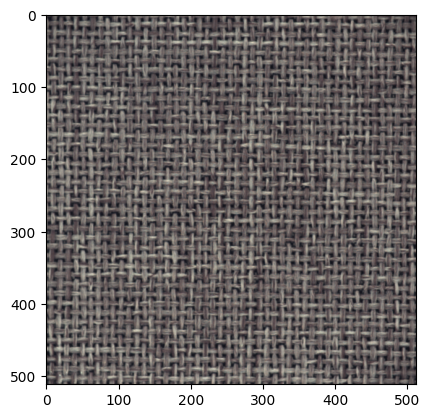

Label: 0


In [3]:
train_features, train_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().permute(1, 2, 0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
# Label 2 is good data, everything else is anomaly

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

class AE(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128):
        super(AE, self).__init__()

        # Encoder: Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 9, kernel_size=5, stride=4, padding=1),  # 3x512x512 -> 9x128x128
            nn.BatchNorm2d(9),
            nn.ReLU(),
            nn.Conv2d(9, 18, kernel_size=5, stride=4, padding=1),  # 9x128x128 -> 18x32x32
            nn.BatchNorm2d(18),
            nn.ReLU(),
            nn.Conv2d(18, 36, kernel_size=3, stride=1, padding=1),  # 18x32x32 -> 36x32x32
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),    # 36x32x32 -> 36x16x16

        )

        self.encoder_bottleneck = nn.Sequential(
            nn.Conv2d(36, 18, kernel_size=3, stride=1, padding=1),    # 36x16x16 -> 18x16x16
            nn.BatchNorm2d(18),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(4608, 4608),
            nn.ReLU(),
            nn.Unflatten(1, (18,16,16)),

            nn.ConvTranspose2d(18, 36, kernel_size=3, stride=1, padding=1, output_padding=0, dilation=1),   # 18x16x16 -> 36x16x16
            nn.BatchNorm2d(36),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(36, 36, kernel_size=2, stride=2, padding=0, output_padding=0), # 36x16x16 -> 36x32x32
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.ConvTranspose2d(36, 18, kernel_size=3, stride=1, padding=1, output_padding=0), # 36x32x32 -> 18x32x32
            nn.BatchNorm2d(18),
            nn.ReLU(),
            nn.ConvTranspose2d(18, 9, kernel_size=4, stride=4, padding=0, output_padding=0), # 18x32x32 -> 9x128x128
            nn.BatchNorm2d(9),
            nn.ReLU(),
            nn.ConvTranspose2d(9, 9, kernel_size=4, stride=4, padding=0, output_padding=0), # 9x128x128 -> 3x512x512
            nn.BatchNorm2d(9),
            nn.ReLU(),

            

            nn.Conv2d(9, 3, kernel_size=1),               # 32x512x512 -> 3x512x512
            nn.Sigmoid()  
        )

    def encode(self, x):
        x = self.encoder(x)
        return x

    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def bottleneck(self, x):
        z = self.encoder_bottleneck(x)
        return z

    def forward(self, x):
        x = self.encode(x)
        x = self.bottleneck(x)
        reconstructed = self.decode(x)
        return reconstructed

model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def ae_loss(reconstructed, original):
    recon_loss = F.mse_loss(reconstructed, original, reduction="sum")
    return recon_loss

checkpoint_path = "C:/Users/Gert/repos/AML-exam-project/project/models/autoencoder_Ver11_40_epochs_checkpoint.pth"

# Load checkpoint if resuming
if os.path.exists(checkpoint_path):  # Ensure file exists
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # Start from next epoch
    losses = checkpoint.get('losses', [])  # Load previous losses if available
    print(f"Resuming from epoch {start_epoch+1}")
else:
    start_epoch = 0
    losses = []


cuda
Loading checkpoint...
Resuming from epoch 40


C:\Users\Gert\AppData\Local\Temp\ipykernel_7172\322831188.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [5]:
model.eval()
with torch.no_grad():
    iter_test_loader = iter(test_dataloader)
    labels = []
    losses = []

    for img_batch, label_batch in iter_test_loader:
        img_batch = img_batch.to(device)
        recon = model(img_batch)
        for i, r in enumerate(recon):
            loss = ae_loss(r, img_batch[i])
            losses.append(loss.item())
            labels.append(label_batch[i].item())

        # break
        


In [34]:
print(len(losses))
print(len(labels))

117
117


In [20]:
# print(img_batch.shape)
# plt.imshow(img_batch[9].cpu().permute(1, 2, 0))
# plt.show()

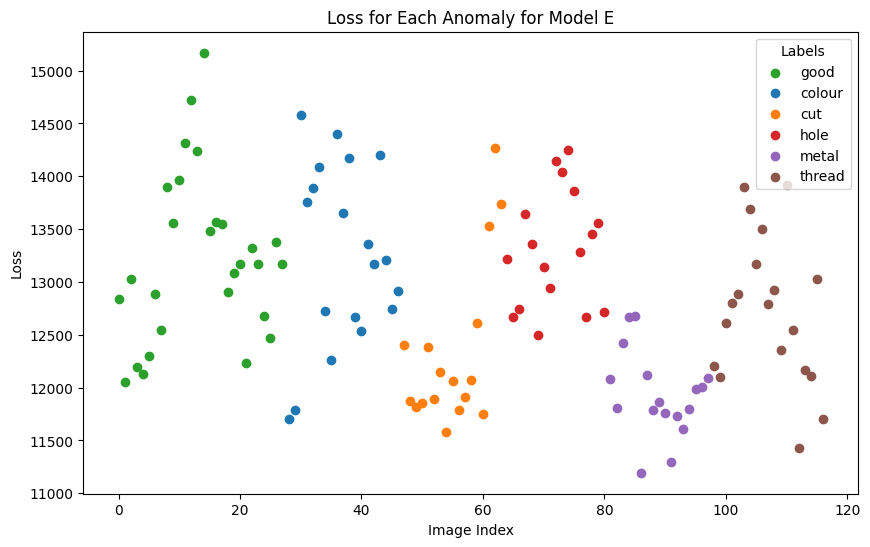

In [6]:
labels = np.array(labels)
losses = np.array(losses)
named_labels = []
for i in labels:
    if i == 0:
        named_labels.append("good")
    if i == 1:
        named_labels.append("colour")
    if i == 2:
        named_labels.append("cut")
    if i == 3:
        named_labels.append("hole")
    if i == 4:
        named_labels.append("metal")
    if i == 5:
        named_labels.append("thread")

# Get unique labels and assign a unique color to each
unique_labels = np.unique(named_labels)
colors = sns.color_palette("tab10", len(unique_labels))  # Use Seaborn's HSV palette
label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
# Plot each point with its corresponding color
plt.figure(figsize=(10, 6))
for i, label in enumerate(named_labels):
    plt.scatter(i, losses[i], color=label_to_color[label], label=f"{label}" if i == list(named_labels).index(label) else "")

# Add legend, axis labels, and title
plt.legend(title="Labels", loc="upper right")
plt.xlabel("Image Index")
plt.ylabel("Loss")
plt.title("Loss for Each Anomaly for Model E")

plt.show()

tensor(2)
(1, 512, 512)


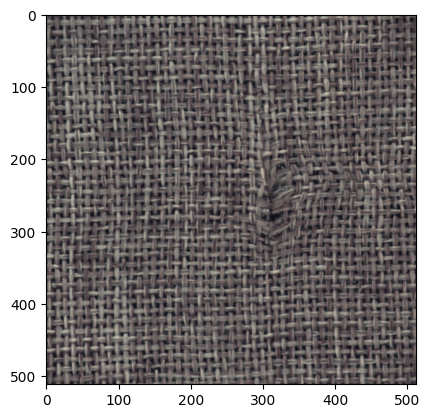

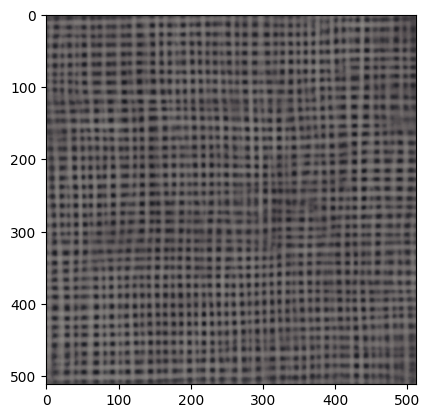

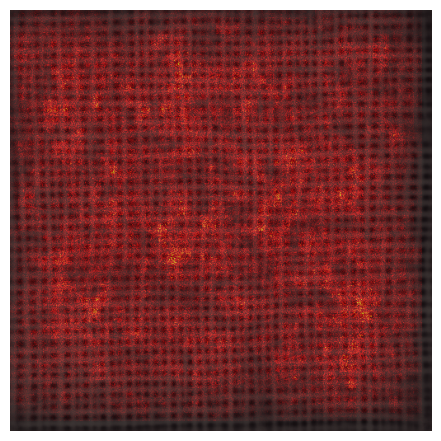

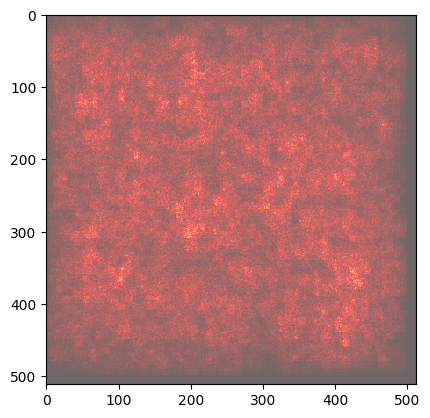

In [29]:
def generate_saliency_map(cnn, image, device='cpu'):
    cnn.eval()  
    image = image[0].unsqueeze(0).to(device)
    image.requires_grad_()  
    
    # forward pass of the CNN
    output = cnn(image)
    output[0].sum().backward()
    # In PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero before starting to do backpropagation 
    # (i.e., updating the Weights and biases) because PyTorch accumulates the gradients on subsequent backward passes. This accumulating behavior is convenient 
    # while training RNNs or when we want to compute the gradient of the loss summed over multiple mini-batches. So, the default action has been set to accumulate (
    # i.e. sum) the gradients on every loss.backward() call.

    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly. 
    # Otherwise, the gradient would be a combination of the old gradient, which you have already used to update your model parameters and the newly-computed gradient.
    # Copied from https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
    cnn.zero_grad()

    saliency_map = image.grad.data.abs()
    saliency_map = saliency_map.max(dim=1)[0]  # Max across channels (C)

    # Normalize the saliency map
    saliency_min, saliency_max = saliency_map.min(), saliency_map.max()
    if saliency_max > saliency_min:  # Avoid division by zero
        saliency_map = (saliency_map - saliency_min) / (saliency_max - saliency_min)
    else:
        saliency_map = saliency_map - saliency_min  # All values become zero if max == min

    return saliency_map.cpu().numpy(), output
model.eval()
with torch.no_grad():
    iter_test_loader = iter(test_dataloader)
    for img_batch, label_batch in iter_test_loader:
        img_batch = img_batch.to(device)
        break
print(label_batch[0])
grad, out = generate_saliency_map(model.to(device), img_batch, device)
# out = out[0]
print(grad.shape)

plt.imshow(img_batch[0].cpu().permute(1, 2, 0))
plt.show()
plt.imshow(out.cpu().detach()[0].permute(1, 2, 0))
plt.show()
plt.imshow(out.cpu().detach()[0].permute(1, 2, 0))
plt.imshow(grad[0], alpha=0.6, cmap="hot")
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()
plt.imshow(grad[0], alpha=0.6, cmap="hot")
plt.show()